Gerando Performance geral de cada modelo

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

Iniciando varredura do diretório: TodasAsRespostasSemX

Varredura concluída.
Provas ordenadas para o heatmap: ['OAB 38', 'OAB 39', 'OAB 40', 'OAB 41', 'OAB 42']

Preparando para gerar heatmap com 5 provas e 80 questões.


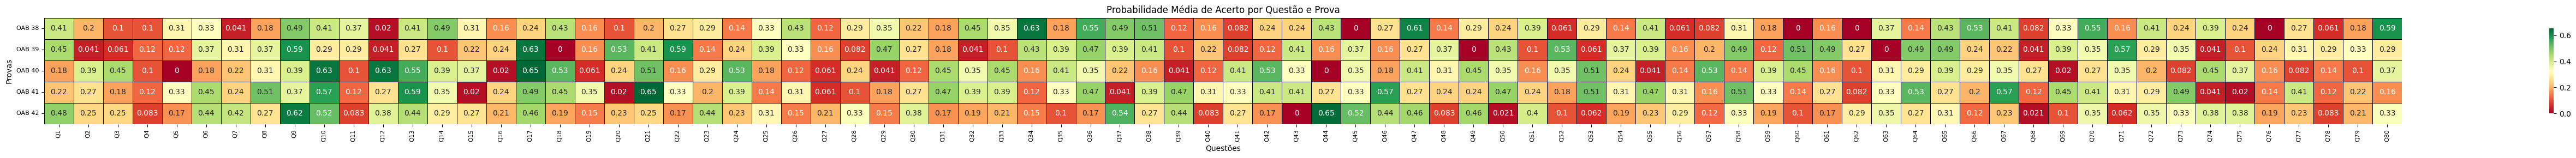

Heatmap gerado com sucesso.


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Configurações
diretorio = "TodasAsRespostasSemX" # Diretório principal
num_questoes = 80 # Número esperado de questões por prova
coluna_respostas = "is_correct" # Nome da coluna com True/False

# Gera os rótulos para as questões (eixo X)
questoes = [f"Q{i}" for i in range(1, num_questoes + 1)]

# Dicionário para armazenar os dados: chave=nome_prova, valor=lista de Series de respostas
dados_por_prova = defaultdict(list)
nome_provas_encontradas = set() # Conjunto para armazenar nomes únicos de provas encontradas

print(f"Iniciando varredura do diretório: {diretorio}")

# --- Passo 1: Coletar todos os resultados agrupados por prova ---
for root, dirs, files in os.walk(diretorio):
    if files:
        # Estrutura esperada: DiretorioGeral / NomeProva / FamiliaIAs / arquivo.csv
        # Pega o caminho da pasta pai (NomeProva)
        caminho_nome_prova = os.path.dirname(root)
        # Extrai o nome da prova do caminho
        nome_prova = os.path.basename(caminho_nome_prova)

        # Adiciona o nome da prova ao conjunto de nomes encontrados
        nome_provas_encontradas.add(nome_prova)

        # Itera sobre cada arquivo encontrado na pasta
        for file in files:
            # Considera apenas arquivos CSV
            if file.lower().endswith(".csv"):
                caminho_arquivo = os.path.join(root, file)
                try:
                    # Lê o arquivo CSV
                    dataframe = pd.read_csv(caminho_arquivo)

                    # Verifica se a coluna esperada existe
                    if coluna_respostas in dataframe.columns:
                        # Extrai a coluna de respostas
                        respostas_raw = dataframe[coluna_respostas]

                        # Tenta converter para booleano de forma segura
                        # Trata casos onde os valores podem ser strings 'True'/'False' ou já booleanos/numéricos
                        if pd.api.types.is_string_dtype(respostas_raw):
                            # Converte strings 'true'/'false' (ignorando maiúsculas/minúsculas) para booleanos
                            respostas = respostas_raw.astype(str).str.lower().map({'true': True, 'false': False})
                        elif pd.api.types.is_numeric_dtype(respostas_raw):
                             # Converte números (1/0) para booleanos
                             respostas = respostas_raw.astype(bool)
                        else:
                             # Assume que já são booleanos ou tipo compatível
                             respostas = respostas_raw.astype(bool)

                        # Remove valores NaN que podem ter surgido da conversão
                        respostas = respostas.dropna()

                        # --- Verificação Crítica: Número de Questões ---
                        if len(respostas) == num_questoes:
                            # Adiciona a Series de booleanos ao dicionário, na chave da prova correspondente
                            dados_por_prova[nome_prova].append(respostas)
                        else:
                            # Alerta se o número de respostas não for o esperado
                            print(f"    AVISO: Arquivo '{file}' na prova '{nome_prova}' tem {len(respostas)} respostas válidas após conversão, esperado {num_questoes}. Arquivo ignorado.")

                    else:
                        # Alerta se a coluna não for encontrada
                        print(f"    AVISO: Coluna '{coluna_respostas}' não encontrada no arquivo '{file}'. Arquivo ignorado.")

                except Exception as e:
                    # Captura erros durante a leitura ou processamento do arquivo
                    print(f"    ERRO: Falha ao ler ou processar o arquivo '{caminho_arquivo}': {e}")

print(f"\nVarredura concluída.")

# Ordena os nomes das provas para garantir uma ordem consistente no heatmap
# (Ex: OAB 38, OAB 39, ...). Ajuste se a ordenação padrão não for adequada.
nome_provas_ordenadas = sorted(list(nome_provas_encontradas))
print(f"Provas ordenadas para o heatmap: {nome_provas_ordenadas}")

# --- Passo 2: Calcular a probabilidade média de acerto por questão para cada prova ---
probabilidades_finais = [] # Lista para armazenar as médias de cada prova
provas_incluidas_heatmap = [] # Lista para os nomes das provas que realmente entrarão no heatmap

for nome_prova in nome_provas_ordenadas:
    lista_respostas_prova = dados_por_prova[nome_prova]

    # Verifica se há dados válidos para esta prova
    if not lista_respostas_prova:
        print(f"AVISO: Nenhuma resposta válida encontrada para a prova '{nome_prova}'. Será omitida do heatmap.")
        continue # Pula para a próxima prova

    try:
        # Empilha todas as Series (respostas de cada modelo) para esta prova em uma matriz NumPy
        # True vira 1, False vira 0. Cada linha é um modelo, cada coluna é uma questão.
        matriz_respostas = np.vstack([s.to_numpy(dtype=float) for s in lista_respostas_prova]) # Converte para float (0.0, 1.0)

        # Calcula a média ao longo das linhas (axis=0) para obter a probabilidade de acerto por questão
        probabilidade_media_prova = np.mean(matriz_respostas, axis=0)

        # Verifica se o resultado tem o número esperado de colunas (questões)
        if len(probabilidade_media_prova) == num_questoes:
            probabilidades_finais.append(probabilidade_media_prova)
            provas_incluidas_heatmap.append(nome_prova) # Adiciona o nome da prova à lista final
        else:
             print(f"  ERRO INESPERADO: Cálculo de probabilidade para '{nome_prova}' resultou em {len(probabilidade_media_prova)} valores. Esperado {num_questoes}. Prova omitida.")

    except ValueError as ve:
        # Erro comum se as Series tiverem tamanhos diferentes (apesar da verificação anterior)
        print(f"  ERRO ao empilhar respostas para '{nome_prova}' - verifique a consistência do número de linhas ({num_questoes}) em todos os CSVs. Detalhes: {ve}. Prova omitida.")
    except Exception as e:
        print(f"  ERRO desconhecido ao calcular probabilidades para '{nome_prova}': {e}. Prova omitida.")


# --- Passo 3: Gerar o Heatmap ---
if not probabilidades_finais:
    print("\nERRO FATAL: Nenhuma probabilidade pôde ser calculada. Heatmap não será gerado.")
else:
    print(f"\nPreparando para gerar heatmap com {len(provas_incluidas_heatmap)} provas e {num_questoes} questões.")

    # Converte a lista de arrays de probabilidade em uma matriz 2D NumPy
    heatmap_data = np.array(probabilidades_finais)

    # Define o tamanho da figura (largura, altura)
    # A altura pode ser ajustada com base no número de provas
    altura_heatmap = max(2, len(provas_incluidas_heatmap) * 0.6) # Ajuste o multiplicador 0.6 conforme necessário
    plt.figure(figsize=(55, altura_heatmap))

    # Cria o heatmap
    sns.heatmap(heatmap_data,
                annot=True,                  
                cmap="RdYlGn",                # Paleta de cores (Amarelo-Verde-Azul)
                xticklabels=questoes,         # Rótulos do eixo X (Q1, Q2, ...)
                yticklabels=provas_incluidas_heatmap, # Rótulos do eixo Y (nomes das provas incluídas)
                linewidths=0.5,               # Linhas finas para separar as células
                linecolor='black',        # Cor das linhas de separação
                cbar_kws={'shrink': .8})      # Ajusta o tamanho da barra de cores

    plt.xticks(rotation=90, fontsize=8)      # Rotaciona rótulos do eixo X e ajusta tamanho da fonte
    plt.yticks(rotation=0, fontsize=8)       # Mantém rótulos do eixo Y horizontais e ajusta fonte
    plt.xlabel("Questões")                   # Rótulo do eixo X
    plt.ylabel("Provas")                     # Rótulo do eixo Y
    plt.title("Probabilidade Média de Acerto por Questão e Prova") # Título do gráfico
    plt.tight_layout()                      # Ajusta o layout para evitar sobreposição de elementos
    plt.show()                              # Exibe o gráfico
    print("Heatmap gerado com sucesso.")



In [ ]:
diretorio = "Diretório com Tabelas de Acerto Todas as IAs"
provas_ja_visitadas = set()
dataframes = []
num_provas = 49
num_questoes_por_prova = 80
for file in os.listdir(diretorio):
    inicio_extensao_csv = 22
    inicio_nome_prova = 16
    nome_prova = file[inicio_nome_prova:inicio_extensao_csv]
    if nome_prova in provas_ja_visitadas:
        continue
    provas_ja_visitadas.add(nome_prova)
    dataframe_geral = pd.read_csv(os.path.join(diretorio, file))
    for outraFile in os.listdir(diretorio):
        if file == outraFile:
            continue
        inicio_outra_extensao_csv = 22
        inicio_outro_nome_prova = 16
        outro_nome_prova = outraFile[inicio_outro_nome_prova:inicio_outra_extensao_csv]
        if nome_prova == outro_nome_prova:
            novo_df = pd.read_csv(os.path.join(diretorio, outraFile))
            dataframe_geral = pd.concat([dataframe_geral, novo_df], ignore_index=True)
    dataframe_geral["Nome_Prova"] = nome_prova
    dataframe_geral = dataframe_geral.drop(columns="model_name")
    dataframe_completo_agrupado = dataframe_geral.groupby("Nome_Prova").sum().reset_index()
    dataframe_completo_agrupado["Aproveitamento"] = dataframe_completo_agrupado["is_correct"] / (num_provas * num_questoes_por_prova)
    print(f"Dataframe completo agrupado para {nome_prova}:\n\n")
    print(dataframe_completo_agrupado.head())
    dataframes.append(dataframe_completo_agrupado)
    print("----------------------\n\n")

Dataframe completo agrupado para OAB 42:


  Nome_Prova  is_correct  Aproveitamento
0     OAB 42        1006        0.256633
----------------------


Dataframe completo agrupado para OAB 39:


  Nome_Prova  is_correct  Aproveitamento
0     OAB 39        1083        0.276276
----------------------


Dataframe completo agrupado para OAB 41:


  Nome_Prova  is_correct  Aproveitamento
0     OAB 41        1190        0.303571
----------------------


Dataframe completo agrupado para OAB 40:


  Nome_Prova  is_correct  Aproveitamento
0     OAB 40        1097        0.279847
----------------------


Dataframe completo agrupado para OAB 38:


  Nome_Prova  is_correct  Aproveitamento
0     OAB 38        1056        0.269388
----------------------




gerando dataframe geral e gráficos

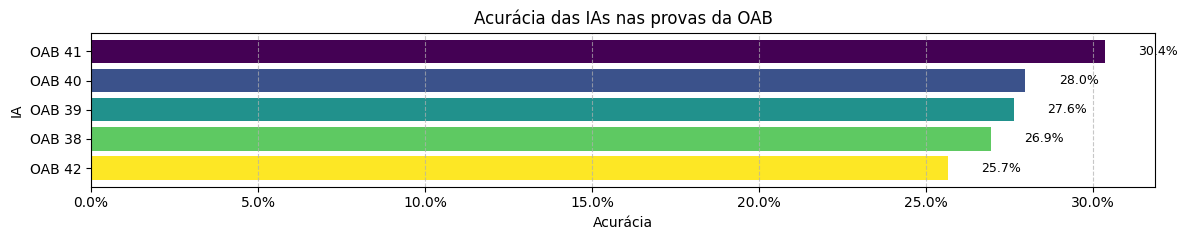

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.ticker as mtick

# Junta os DataFrames e ordena
df_completo = pd.concat(dataframes, ignore_index=True)
df_completo = df_completo.sort_values(by="Aproveitamento", ascending=False)

# Cores e tamanho
num_cores = len(df_completo)
colors = cm.viridis(np.linspace(0, 1, num_cores))
altura = 0.5 * len(df_completo)
plt.figure(figsize=(12, altura))

# Gráfico de barras
plt.barh(df_completo["Nome_Prova"], df_completo["Aproveitamento"], color=colors)

# Eixos e título
plt.xlabel("Acurácia")
plt.ylabel("IA")
plt.title("Acurácia das IAs nas provas da OAB")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Formatar eixo X como porcentagem
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Adicionar valores ao lado das barras
for i, (acuracia, nome) in enumerate(zip(df_completo["Aproveitamento"], df_completo["Nome_Prova"])):
    plt.text(acuracia + 0.01, i, f"{acuracia:.1%}", va='center', fontsize=9)

plt.tight_layout()
plt.show()
